In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

# Define model and create sample trajectory

In [2]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            
gIh   = 1/14
gIc   = 1/14
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter
fh = 0.1 
gE    = 1/5
gA    = 1/3

hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
cc   = 0.05*np.ones(M)      # fraction which goes from  hospital to ICU 
mm   = 0.4*np.ones(M)       # mortality from IC
sa = 0  # change in the population, not taken into account by inference at the moment 

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([0, 0])  # each age group has asymptomatic infectives
Is0 = np.array([0, 0])   # and also symptomatic infectives
R0  = np.zeros((M))
E0  = np.array([10, 10])
A0  = np.array([10, 10])
Ih0  = np.zeros((M))
Ic0  = np.zeros((M))
Im0  = np.zeros((M))
S0  = Ni - (Ia0+Is0+R0+E0+A0+Ih0+Ic0+Im0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEAI5R(parameters, M, Ni)
data = sto_model.simulate(S0, E0, A0, Ia0, Is0, Ih0, Ic0, Im0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('sto_traj.npy', data_array)

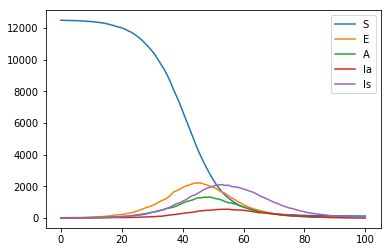

In [3]:
# plot the stochastic solution 
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='E')
plt.plot(data_array[:, 2*M], label='A')
plt.plot(data_array[:, 3*M], label='Ia')
plt.plot(data_array[:, 4*M], label='Is')

plt.legend()
plt.show()

# Infer parameters based on part of the trajectory

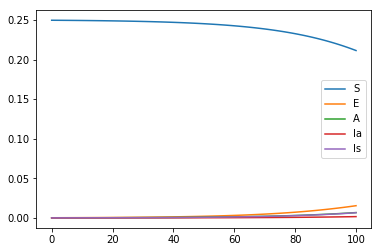

In [4]:
# load the data and rescale to intensive variables 
Tf_inference = 30 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1

x = np.load('sto_traj.npy').astype('float')
x = (x[:,:8*M]/N)[:Nf_inference]
steps = 101 # number internal integration steps taken


# initialise the estimator 
estimator = pyross.inference.SEAI5R(parameters, M, fi, int(N), steps)

det_model = pyross.deterministic.SEAI5R(parameters, M, fi)
x_det = estimator.integrate(x[0], 0, Tf_inference, det_model, contactMatrix)

In [5]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-2286.1724660808586
0.7895150184631348


In [6]:
alpha_g = 0.3
beta_g = 0.1
gIa_g = 0.2 
gIs_g = 0.2 
gE_g = 0.4
gA_g = 0.5 

guess = [alpha_g, beta_g, gIa_g, gIs_g, gE_g, gA_g]
params, nit = estimator.inference(guess, x, Tf_inference, Nf_inference, 
                                  contactMatrix, ftol=1e-6, verbose=True)

print('best estimates: ', params)
print('no. of iterations: ', nit)

[0.3 0.1 0.2 0.2 0.4 0.5] 3580.7950643905097
[0.30001 0.1     0.2     0.2     0.4     0.5    ] 3580.7976946266676
[0.3     0.10001 0.2     0.2     0.4     0.5    ] 3581.4771828278463
[0.3     0.1     0.20001 0.2     0.4     0.5    ] 3580.7971522252365
[0.3     0.1     0.2     0.20001 0.4     0.5    ] 3580.8114502394114
[0.3     0.1     0.2     0.2     0.40001 0.5    ] 3580.8045511796154
[0.3     0.1     0.2     0.2     0.4     0.50001] 3580.803608539766
[1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05] 5149170618.384798
[2.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05] 3163055313.672336
[1.e-05 2.e-05 1.e-05 1.e-05 1.e-05 1.e-05] 5146989656.042579
[1.e-05 1.e-05 2.e-05 1.e-05 1.e-05 1.e-05] 5147943464.415109
[1.e-05 1.e-05 1.e-05 2.e-05 1.e-05 1.e-05] 4591866262.223398
[1.e-05 1.e-05 1.e-05 1.e-05 2.e-05 1.e-05] 5136412938.383734
[1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 2.e-05] 2597239547.6872573
[0.2000058  0.06667082 0.13333831 0.13333831 0.2666733  0.33334079] 789.6344294447703
[0.2000158  0.0666708

[0.19047262 0.02003506 0.12669149 0.1473384  0.19540084 0.32395347] -2286.2320715024866
[0.19047262 0.02003506 0.12668149 0.1473484  0.19540084 0.32395347] -2286.231083013347
[0.19047262 0.02003506 0.12668149 0.1473384  0.19541084 0.32395347] -2286.231273073108
[0.19047262 0.02003506 0.12668149 0.1473384  0.19540084 0.32396347] -2286.231450760197
[0.19265813 0.02002285 0.12927799 0.14699281 0.19560138 0.32594599] -2286.4400774330466
[0.19266813 0.02002285 0.12927799 0.14699281 0.19560138 0.32594599] -2286.440379365123
[0.19265813 0.02003285 0.12927799 0.14699281 0.19560138 0.32594599] -2286.4403243704596
[0.19265813 0.02002285 0.12928799 0.14699281 0.19560138 0.32594599] -2286.440677956713
[0.19265813 0.02002285 0.12927799 0.14700281 0.19560138 0.32594599] -2286.4395886028915
[0.19265813 0.02002285 0.12927799 0.14699281 0.19561138 0.32594599] -2286.4397686174207
[0.19265813 0.02002285 0.12927799 0.14699281 0.19560138 0.32595599] -2286.4397547164704
[0.1992143  0.02000957 0.13789904 0.1

[0.33158599 0.02002365 0.32523901 0.09524422 0.19524115 0.32360589] -2294.7925454271544
basinhopping step 0: f -2294.79
[0.32945721 0.04321983 0.28583995 0.14770051 0.2370411  0.30405614] -1025.3227304038267
[0.32946721 0.04321983 0.28583995 0.14770051 0.2370411  0.30405614] -1025.3197478062116
[0.32945721 0.04322983 0.28583995 0.14770051 0.2370411  0.30405614] -1024.5857867652574
[0.32945721 0.04321983 0.28584995 0.14770051 0.2370411  0.30405614] -1025.3215425992767
[0.32945721 0.04321983 0.28583995 0.14771051 0.2370411  0.30405614] -1025.3102378263097
[0.32945721 0.04321983 0.28583995 0.14770051 0.2370511  0.30405614] -1025.3107518124755
[0.32945721 0.04321983 0.28583995 0.14770051 0.2370411  0.30406614] -1025.326452031672
[1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 2.5e+00] 35716867.09704636
[2.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 2.5e+00] 35290453.4771926
[1.0e-05 2.0e-05 1.0e-05 1.0e-05 1.0e-05 2.5e+00] 33382506.781801976
[1.0e-05 1.0e-05 2.0e-05 1.0e-05 1.0e-05 2.5e+00] 35510960.55

[0.31650468 0.02000788 0.27927715 0.1102125  0.19216286 0.32390111] -2292.8612238311675
[0.31649468 0.02001788 0.27927715 0.1102125  0.19216286 0.32390111] -2292.864020044793
[0.31649468 0.02000788 0.27928715 0.1102125  0.19216286 0.32390111] -2292.862551366708
[0.31649468 0.02000788 0.27927715 0.1102225  0.19216286 0.32390111] -2292.8600314554974
[0.31649468 0.02000788 0.27927715 0.1102125  0.19217286 0.32390111] -2292.8640932364237
[0.31649468 0.02000788 0.27927715 0.1102125  0.19216286 0.32391111] -2292.8621680365927
[0.3163125  0.01996036 0.27927969 0.10984771 0.19232018 0.32413318] -2292.9629520531626
[0.3163225  0.01996036 0.27927969 0.10984771 0.19232018 0.32413318] -2292.9619779587883
[0.3163125  0.01997036 0.27927969 0.10984771 0.19232018 0.32413318] -2292.969517435504
[0.3163125  0.01996036 0.27928969 0.10984771 0.19232018 0.32413318] -2292.963288592592
[0.3163125  0.01996036 0.27927969 0.10985771 0.19232018 0.32413318] -2292.960874042089
[0.3163125  0.01996036 0.27927969 0.1

[0.30600435 0.02004615 0.28851288 0.10427704 0.19540711 0.32281079] -2294.495186281983
[0.30600435 0.02004615 0.28851288 0.10426704 0.19541711 0.32281079] -2294.4950192130655
[0.30600435 0.02004615 0.28851288 0.10426704 0.19540711 0.32282079] -2294.4953394095
[0.3060336  0.02000042 0.28880298 0.10429479 0.19449514 0.32326976] -2294.491619198232
[0.3060436  0.02000042 0.28880298 0.10429479 0.19449514 0.32326976] -2294.491695561919
[0.3060336  0.02001042 0.28880298 0.10429479 0.19449514 0.32326976] -2294.49397131981
[0.3060336  0.02000042 0.28881298 0.10429479 0.19449514 0.32326976] -2294.4917116332763
[0.3060336  0.02000042 0.28880298 0.10430479 0.19449514 0.32326976] -2294.491564641942
[0.3060336  0.02000042 0.28880298 0.10429479 0.19450514 0.32326976] -2294.491993402847
[0.3060336  0.02000042 0.28880298 0.10429479 0.19449514 0.32327976] -2294.4916676194384
[0.3060172  0.02002606 0.28864031 0.10427923 0.19500653 0.32301239] -2294.503310844829
[0.3060272  0.02002606 0.28864031 0.1042792

[0.37654816 0.01477594 0.26154836 0.10839111 0.19548841 0.21307078] -1942.5807058312807
[0.37654816 0.01476594 0.26155836 0.10839111 0.19548841 0.21307078] -1941.7478878133218
[0.37654816 0.01476594 0.26154836 0.10840111 0.19548841 0.21307078] -1941.7403369671483
[0.37654816 0.01476594 0.26154836 0.10839111 0.19549841 0.21307078] -1941.748047969733
[0.37654816 0.01476594 0.26154836 0.10839111 0.19548841 0.21308078] -1941.7779129823696
[0.46909944 0.03795663 0.24144438 0.17551372 0.09682785 0.12298236] 271.2742934328896
[0.46910944 0.03795663 0.24144438 0.17551372 0.09682785 0.12298236] 271.2942350431847
[0.46909944 0.03796663 0.24144438 0.17551372 0.09682785 0.12298236] 271.97982088646546
[0.46909944 0.03795663 0.24145438 0.17551372 0.09682785 0.12298236] 271.2664787647675
[0.46909944 0.03795663 0.24144438 0.17552372 0.09682785 0.12298236] 271.29702870192034
[0.46909944 0.03795663 0.24144438 0.17551372 0.09683785 0.12298236] 271.0970740905749
[0.46909944 0.03795663 0.24144438 0.1755137

[0.32416238 0.02002176 0.31461566 0.09791937 0.19510279 0.32371658] -2294.770084815017
[0.32416238 0.02002176 0.31460566 0.09792937 0.19510279 0.32371658] -2294.7700448306346
[0.32416238 0.02002176 0.31460566 0.09791937 0.19511279 0.32371658] -2294.7700482285395
[0.32416238 0.02002176 0.31460566 0.09791937 0.19510279 0.32372658] -2294.7700386636297
basinhopping step 2: f -2294.77 trial_f -2294.77 accepted 1  lowest_f -2294.79
best estimates:  [0.33158599 0.02002365 0.32523901 0.09524422 0.19524115 0.32359589]
no. of iterations:  2


In [7]:
# compute log_p for best estimate 
start_time = time.time() 
parameters = estimator.make_params_dict(params)
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-2294.792538961961
0.809161901473999


In [8]:
hessian = estimator.hessian(params,x,Tf_inference,Nf_inference,contactMatrix)
cov = np.linalg.inv(hessian)
#cov

# Compare forecast based on inferred parameters to full trajectory

In [10]:
parameters = {'alpha': params[0], 'beta': params[1], 'gIa': params[2], 'gIs': params[3],
              'gE':params[4],'gA':params[5],
                 'fsa':fsa, 'fh':fh, 
              'gIh':gIh,'gIc':gIc,
              'sa':sa, 
              'hh':hh, 'cc':cc, 'mm':mm,
             'cov':cov}

# Initialise pyross forecast module
model_forecast = pyross.forecast.SEAI5R(parameters, M, Ni)

In [15]:
# Initial condition for forecast is last configuration from inference-trajectory
S0_forecast = x[-1,:M]*N
E0_forecast = x[-1,M:2*M]*N
A0_forecast = x[-1,2*M:3*M]*N
Ia0_forecast = x[-1,3*M:4*M]*N
Is0_forecast = x[-1,4*M:5*M]*N
Ih0_forecast = x[-1,5*M:6*M]*N
Ic0_forecast = x[-1,6*M:7*M]*N
Im0_forecast = x[-1,7*M:   ]*N


# Number of simulations over which we average
Ns = 500 

Tf_forecast = Tf - Tf_inference
Nf_forecast = Tf_forecast+1


result_forecast = model_forecast.simulate(S0_forecast, E0_forecast, A0_forecast,Ia0_forecast,
                                           Is0_forecast, Ih0_forecast,Ic0_forecast, Im0_forecast, 
                                          contactMatrix, Tf_forecast, Nf_forecast,
                                      verbose=True,
                                     Ns=Ns) 

trajectories_forecast = result_forecast['X']
t_forecast = result_forecast['t'] + Tf_inference

Finished. Time needed for evaluation: 00:00:04


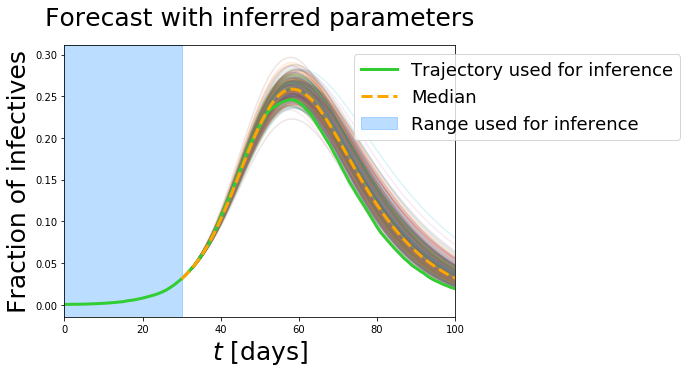

In [19]:
# Plot sum of A, Ia, Is populations

fontsize=25
#

ylabel=r'Fraction of infectives'
#

# Plot total number of symptomatic infectives
cur_trajectories_forecast = np.sum( trajectories_forecast[:,2*M:5*M,:] , axis = 1)
cur_mean_forecast = np.mean( cur_trajectories_forecast, axis=0)
percentile = 10
percentiles_lower = np.percentile(cur_trajectories_forecast,percentile,axis=0)
percentiles_upper = np.percentile(cur_trajectories_forecast,100-percentile,axis=0)
percentiles_median = np.percentile(cur_trajectories_forecast,50,axis=0)


cur_trajectory_underlying = np.sum( data_array[:,2*M:5*M] ,axis=1 )

#
# Plot trajectories
#
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.axvspan(0, Tf_inference, 
           label='Range used for inference',
           alpha=0.3, color='dodgerblue')
ax.set_title(r'Forecast with inferred parameters',
             y=1.05,
            fontsize=fontsize)
for i,e in enumerate(cur_trajectories_forecast):
    ax.plot(t_forecast,e/N,
            alpha=0.15,
           )
ax.plot(cur_trajectory_underlying/N,
        lw=3,
        color='limegreen',
       label='Trajectory used for inference')

ax.plot(t_forecast,percentiles_median/N,
                alpha=1,ls='--',
        color='orange',label='Median',
       lw=3)
''' # remove comments to plot percentiles
ax.plot(t_forecast,percentiles_lower/N,
                alpha=1,
        lw=2,
        label='Percentiles',
        ls='dotted',
        color='red',
       )
ax.plot(t_forecast,percentiles_upper/N,
                alpha=1,
        lw=2,
        color='red',
        ls='dotted',
       )
''';

ax.set_xlim(0,np.max(t_forecast))
ax.set_ylabel(ylabel,fontsize=fontsize)
ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
ax.legend(loc='upper right',bbox_to_anchor=(1.6,1),
          fontsize=18)
plt.show(fig)
#fig.savefig('inference_forecast.png',dpi=100,bbox_inches='tight')
plt.close(fig)